# Agglomerative Clustering

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from stop_words import get_stop_words
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

from utils import add_epoch_division, linkage_matrix, plot_dendrogram, remove_noise_poet, text_cleaning

In [63]:
DIM_RED = False
LOWERCASE = True
MAX_FEATURES = 10000
PATH = "../corpora/amann_poems.csv"
PRELOAD = True
REDUCE_CORPUS = False
STOP_WORDS = get_stop_words("de")

In [64]:
corpus = text_cleaning(pd.read_csv(PATH, index_col=0))

In [65]:
if not PRELOAD:
    with open("epochs.json") as f:
        epochs = json.loads(f.read())

    epochs = epochs["amann"]
    epoch_exceptions = ["Sturm_Drang"]
    corpus = add_epoch_division(corpus, epochs, epoch_exceptions=epoch_exceptions)
    corpus = merge_corpus_poets(corpus)
    corpus = corpus[corpus.epoch != ""]

In [66]:
# reduce corpus
if REDUCE_CORPUS:
    epoch1 = "Frühaufklärung"
    epoch2 = "Realismus"
    corpus = corpus[(corpus.epoch == epoch1) | (corpus.epoch == epoch2)]

In [67]:
vectorizer = TfidfVectorizer(max_df=0.5,
                             lowercase=LOWERCASE,
                             max_features=MAX_FEATURES,
                             stop_words=STOP_WORDS)
vector = vectorizer.fit_transform(corpus["poem"])

In [107]:
text = corpus["poem"]
shortened_classes = [c[:2] for c in corpus["epoch"].values]
ids = [p for p in corpus["id"].values]

## Clustering

In [69]:
if DIM_RED:
    pca = PCA(n_components=3)
    X_red = pca.fit_transform(vector.toarray())
else:
    X_red = vector.toarray()

In [70]:
%%time
agcl = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model = agcl.fit(X_red)

CPU times: user 549 ms, sys: 7.09 ms, total: 556 ms
Wall time: 569 ms


In [71]:
def get_font_size(p):
    font_size = 12-p
    if font_size < 4:
        font_size = 4
    return font_size    

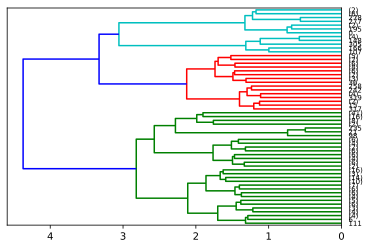

In [72]:
p = 5
cluster_labels = ids

l = dendrogram(linkage_matrix(model), 
               p=p, 
               truncate_mode='level', 
               labels=cluster_labels, 
               orientation="left",
               leaf_font_size=get_font_size(p),
               no_plot=False,
               show_leaf_counts=True,
               show_contracted=False,
               get_leaves=True)
plt.show()

In [73]:
for i in range(1,20):

    p = i
    cluster_labels = ids

    l = dendrogram(linkage_matrix(model), 
                   p=p, 
                   truncate_mode='level', 
                   labels=cluster_labels, 
                   orientation="left",
                   leaf_font_size=get_font_size(p),
                   no_plot=True,
                   show_leaf_counts=False,
                   show_contracted=False,
                   get_leaves=True)
    
    print(f"{p} \t {len(l['ivl'])}")

1 	 4
2 	 8
3 	 16
4 	 32
5 	 57
6 	 95
7 	 142
8 	 186
9 	 216
10 	 232
11 	 243
12 	 252
13 	 257
14 	 260
15 	 262
16 	 262
17 	 262
18 	 262
19 	 262


In [126]:
p = 8
cluster_labels = ids

l = dendrogram(linkage_matrix(model), 
               p=p, 
               truncate_mode='level', 
               labels=cluster_labels, 
               orientation="left",
               leaf_font_size=get_font_size(p),
               no_plot=True,
               show_leaf_counts=False,
               show_contracted=False,
               get_leaves=True)

print(f"{p} \t {len(l['ivl'])}")

8 	 186


### Remove noise

In [127]:
not_noise = [leaf for leaf in l["ivl"] if leaf != ""]
noise = [leaf for leaf in ids if leaf not in not_noise]

noise_df = corpus[corpus["id"].isin(noise)]
noiseless_df = corpus[corpus["id"].isin(not_noise)]

In [114]:
#noiseless_df.to_csv("../corpora/amann_poems_noiseless.csv", index=False)